In [1]:
## Imports
import glob 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import pickle 




## MC_Maze target locations and condition ids 

* [12 84]  (2, 0)  
* [123  69] (3, 0) 
* [-126   15] (4, 0)
* [124 -79] (6, 0)  
* [103  83] (7, 0)  
* [-105   76] (8, 0) 
* [123 -81]  (10, 0) 
* [123  71] (11, 0)  
* [-130  -13] (12, 0)  


Todo 
* Add train scores too 
* Add std values 
* Increase the MC samples to 20 or 25 to make sure variance is small 

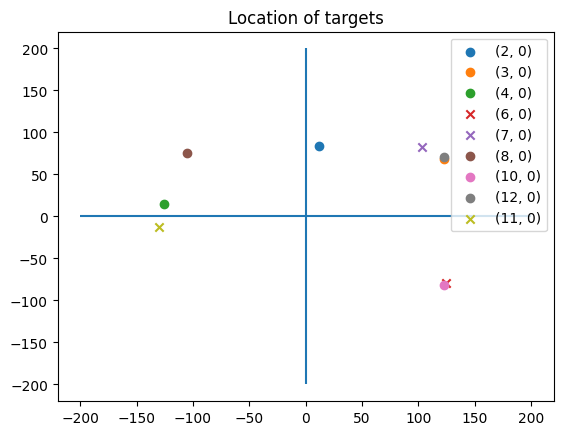

In [13]:
# split train and test conditions -- split selected based on the target locations above 
conds =  [(2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (10, 0), (12, 0), (11, 0)]
train_conds = [(2, 0), (3, 0), (4, 0), (8, 0), (10, 0), (12, 0)]
test_conds = [(6, 0), (11, 0),(7,0)]


points = [[12, 84],
 [123, 69],
 [-126,   15],
 [124, -79], 
 [103, 83], 
 [-105,   76],
 [123, -81],
 [123 , 71], 
 [-130,  -13] ]
points = np.array(points)

import matplotlib.pyplot as plt 
# plt.plot(points[:,0], points[0, :])
for i in range(len(points)):
    if conds[i] in train_conds:
        plt.scatter(points[i, 0], points[i, 1], label=f'{conds[i]}')
    else:
        plt.scatter(points[i, 0], points[i, 1], label=f'{conds[i]}', marker='x')
    
plt.hlines(0, -200, 200)
plt.vlines(0, -200, 200)
plt.title('Location of targets')
plt.legend()

In [59]:
import random 
random.seed(0)

conds =  [(2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (10, 0), (12, 0), (11, 0)]
for i in range(10):
    random.shuffle(conds )
    print(conds)
    train_conds, test_conds = conds[:-3], conds[-3:]

[(12, 0), (8, 0), (3, 0), (6, 0), (7, 0), (4, 0), (2, 0), (11, 0), (10, 0)]
6 3
[(3, 0), (12, 0), (6, 0), (10, 0), (2, 0), (8, 0), (7, 0), (4, 0), (11, 0)]
6 3
[(6, 0), (3, 0), (10, 0), (11, 0), (7, 0), (8, 0), (4, 0), (2, 0), (12, 0)]
6 3
[(2, 0), (4, 0), (12, 0), (10, 0), (6, 0), (7, 0), (11, 0), (8, 0), (3, 0)]
6 3
[(4, 0), (11, 0), (7, 0), (2, 0), (12, 0), (6, 0), (3, 0), (8, 0), (10, 0)]
6 3
[(7, 0), (12, 0), (10, 0), (2, 0), (4, 0), (8, 0), (6, 0), (3, 0), (11, 0)]
6 3
[(10, 0), (2, 0), (7, 0), (11, 0), (6, 0), (4, 0), (3, 0), (12, 0), (8, 0)]
6 3
[(4, 0), (3, 0), (12, 0), (10, 0), (11, 0), (6, 0), (7, 0), (8, 0), (2, 0)]
6 3
[(10, 0), (4, 0), (8, 0), (12, 0), (2, 0), (11, 0), (7, 0), (6, 0), (3, 0)]
6 3
[(12, 0), (3, 0), (10, 0), (6, 0), (8, 0), (4, 0), (2, 0), (11, 0), (7, 0)]
6 3


In [69]:
# load data for conditions 


def load_data_kinematics(f, swapaxes=True):
    with open(f, 'rb') as f_:
        data = pickle.load(f_)

        Y = data['data'].astype(np.float32)
        if swapaxes: Y = Y.swapaxes(-1, -2)

        # trial x T x direction
        hand_vel = data['hand_velocity']

    return Y, hand_vel


data = {k: None for k in conds}

# load behavior data 
for cond in conds:
    file = f'../../datasets/MC_Maze_L/data_5_cond{cond[0]}_{cond[1]}.pkl'
    Y, behavior = load_data_kinematics(file)
    
    
#     shuffle_seed = 0 # default shuffle seed used in experiments 
#     rng = np.random.default_rng(shuffle_seed)
#     rng.shuffle(Y)
         
#     shuffle_seed = 0
#     rng = np.random.default_rng(shuffle_seed)
#     rng.shuffle(behavior)
    
    behavior_train = behavior
    
    data[cond] = {
        'behavior': {
            'train': behavior_train,
        },
    }
    


In [4]:
del behavior

## Utilities 

In [70]:
def test_decode(train_rates, test_rates, train_behavior, test_behavior):
    
#     gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 50)})
    gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 50)})
    gscv.fit(train_rates, 
             train_behavior)
    assert train_rates.shape[0] == train_behavior.shape[0]
    pred_vel = gscv.predict(train_rates)
    # pred_vel_test = gscv.predict(test_rates)
    
    train_score = gscv.best_score_
    plt.plot(gscv.predict(test_rates)[:, 0], label='pred')
    plt.plot(test_behavior[:, 0], label='true')
    plt.legend()
    plt.figure()
    
    plt.plot(gscv.predict(test_rates)[:, 1], label='pred')
    plt.plot(test_behavior[:, 1], label='true')
    plt.legend()
    
    test_score = gscv.score(test_rates, test_behavior)
    print(f'Train score - {train_score:.3f}, test score - {test_score:.3f}')
    return train_score, test_score



def load_data(conds, exp_type, model='ccgpfa', n_inducing=None):
    rates, behavior = [], []
        
    
    for cond in conds:
        
        files = []
        
        if model == 'ccgpfa':
#             files = glob.glob(f'{path}data_5_cond{cond[0]}_{cond[1]}/{exp_type}*100/*.pkl') # old
            files = glob.glob(f'{path}data_5_cond{cond[0]}_{cond[1]}/{exp_type}*{n_inducing}*/*.pkl') # new 
#             print(f'{path}data_5_cond{cond[0]}_{cond[1]}/{exp_type}*None/*.pkl')
        elif model == 'bgpfa':
            files = glob.glob(f'{path}data_5_cond{cond[0]}_{cond[1]}/bgpfa_{exp_type}/*.pkl')
        elif model == 'pal':
            files = glob.glob(f'{path}/data_5_cond{cond[0]}_{cond[1]}*.pkl')
        # print(cond, model, files, exp_type )
        if files:
            result = pickle.load( open(files[0], 'rb' )) 
            
            
            behavior.append(data[cond]['behavior']['train'])
            
            if model == 'ccgpfa' or model =='pal':
                rates.append(
                    result['train']['firing_rates'][None, ...].repeat(behavior[-1].shape[0], axis=0)
                )
            elif model == 'bgpfa':
                rates.append(
                    result['train']['firing_rates']
                )
                
            assert rates[-1].shape[0] == behavior[-1].shape[0] 
    
    return rates, behavior 

In [16]:
# times = [ pickle.load(open(f, 'rb'))['train']['elapsed_time'] for f in glob.glob('/media/yido/additional/research/Gitlab/gpfa/icml_experiments/MC_Maze_L/data_5_cond*/negbinom*100/*.pkl')]
# times = [ pickle.load(open(f, 'rb'))['train']['elapsed_time'] for f in glob.glob('/media/yido/additional/research/Gitlab/gpfa/icml_experiments/MC_Maze_L/data_5_cond*/binom*100/*.pkl')]

# np.mean(times) * 9 / 60  


## Behavioral Prediction Results 

### ccGPFA - Neg Binomial 

[(12, 0), (8, 0), (3, 0), (6, 0), (7, 0), (4, 0), (2, 0), (11, 0), (10, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.748, test score - 0.792
[(3, 0), (12, 0), (6, 0), (10, 0), (2, 0), (8, 0), (7, 0), (4, 0), (11, 0)]
(10900, 162) (5600, 162) (10900, 2) (5600, 2)
Train score - 0.643, test score - 0.768
[(6, 0), (3, 0), (10, 0), (11, 0), (7, 0), (8, 0), (4, 0), (2, 0), (12, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.567, test score - 0.411
[(2, 0), (4, 0), (12, 0), (10, 0), (6, 0), (7, 0), (11, 0), (8, 0), (3, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.655, test score - 0.757
[(4, 0), (11, 0), (7, 0), (2, 0), (12, 0), (6, 0), (3, 0), (8, 0), (10, 0)]
(11100, 162) (5400, 162) (11100, 2) (5400, 2)
Train score - 0.452, test score - 0.849
[(7, 0), (12, 0), (10, 0), (2, 0), (4, 0), (8, 0), (6, 0), (3, 0), (11, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.711, test score - 0.815
[(10, 0), (2, 0), (7, 0), (1

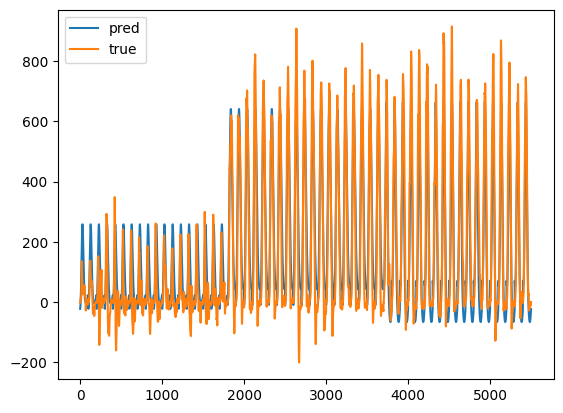

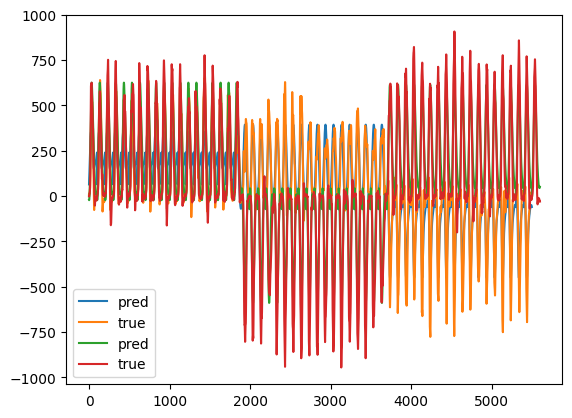

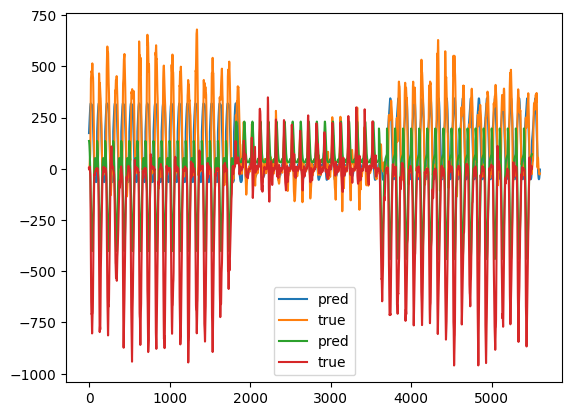

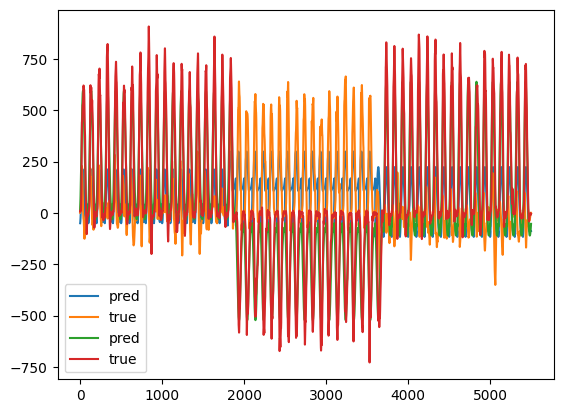

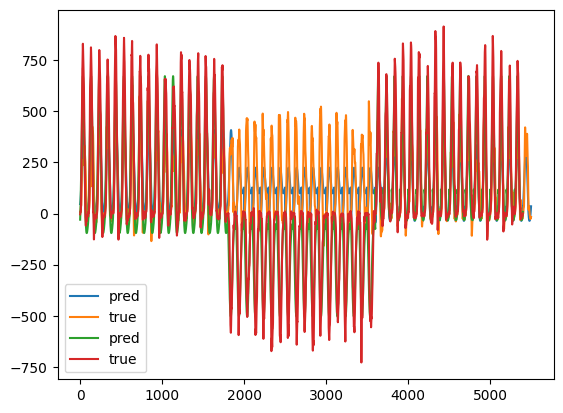

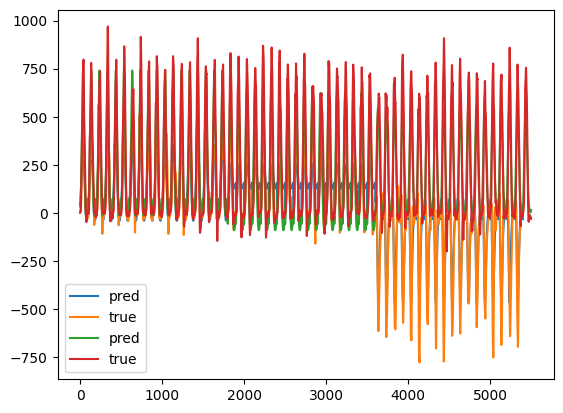

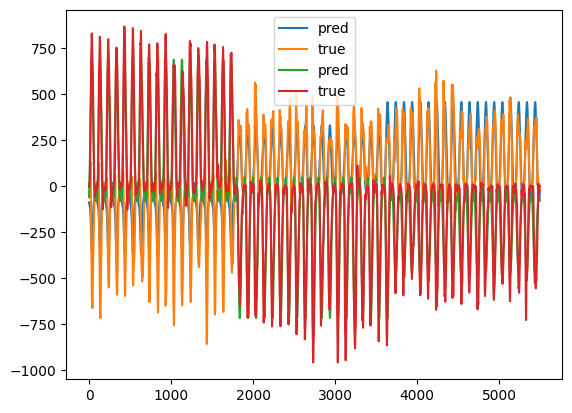

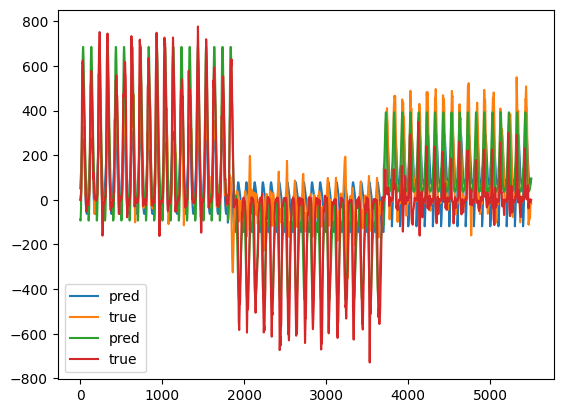

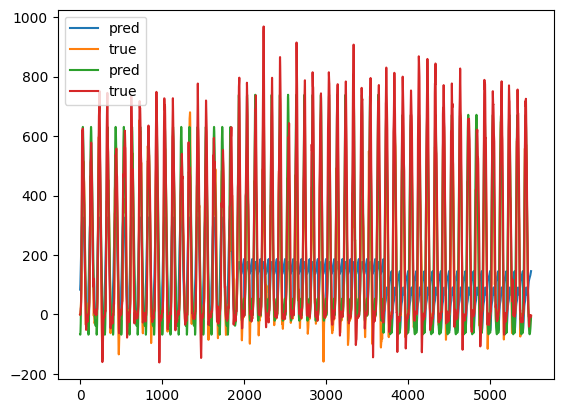

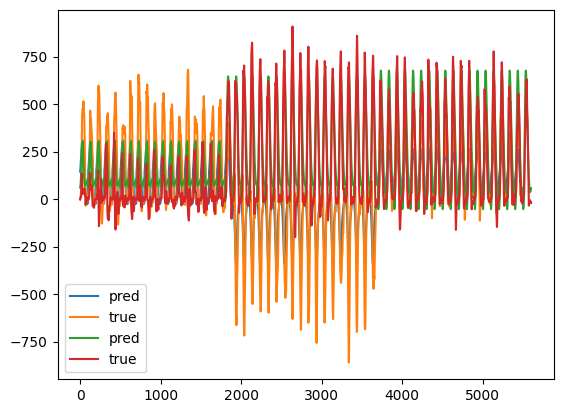

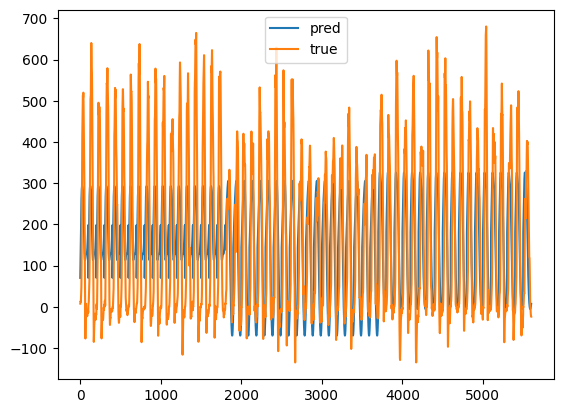

In [71]:
import glob 

path = '' # set path to ccGPFA experiment results (base directory) 
path = '/media/yido/additional/research/Gitlab/gpfa/ccgpfa/output/MC_Maze_L/' # new 
# path = '/media/yido/additional/research/Gitlab/gpfa/icml_experiments/MC_Maze_L/' # old 

n_inducing = None # 70 # None 

exp_type = 'negbinom' # 'binom'
train_rates, train_behavior = [], []
test_rates, test_behavior = [], []

import random 
random.seed(0) # change this to rng 
conds =  [(2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (10, 0), (12, 0), (11, 0)]
test_scores = []
for i in range(10):
    random.shuffle(conds )
    print(conds)
    train_conds, test_conds = conds[:-3], conds[-3:]

    train_rates, train_behavior = load_data(train_conds, exp_type, model='ccgpfa', n_inducing=n_inducing)
    test_rates, test_behavior = load_data(test_conds, exp_type, model='ccgpfa', n_inducing=n_inducing)


    train_rates = np.vstack(np.vstack(train_rates).swapaxes(-1, -2))
    train_behavior = np.vstack(np.vstack(train_behavior))

    test_rates = np.vstack(np.vstack(test_rates).swapaxes(-1, -2))
    test_behavior = np.vstack(np.vstack(test_behavior))
    print(train_rates.shape, test_rates.shape, train_behavior.shape, test_behavior.shape )

    _, test_score_ = test_decode(train_rates, test_rates, train_behavior, test_behavior)
    test_scores.append(test_score_)
print(np.mean(test_scores))

In [35]:
# whos 

In [88]:
# plt.plot(train_rates[:, 2])

### ccGPFA - Binomial 

[(12, 0), (8, 0), (3, 0), (6, 0), (7, 0), (4, 0), (2, 0), (11, 0), (10, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.493, test score - 0.653
[(3, 0), (12, 0), (6, 0), (10, 0), (2, 0), (8, 0), (7, 0), (4, 0), (11, 0)]
(10900, 162) (5600, 162) (10900, 2) (5600, 2)
Train score - 0.483, test score - 0.533
[(6, 0), (3, 0), (10, 0), (11, 0), (7, 0), (8, 0), (4, 0), (2, 0), (12, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.478, test score - 0.010
[(2, 0), (4, 0), (12, 0), (10, 0), (6, 0), (7, 0), (11, 0), (8, 0), (3, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.476, test score - 0.144
[(4, 0), (11, 0), (7, 0), (2, 0), (12, 0), (6, 0), (3, 0), (8, 0), (10, 0)]
(11100, 162) (5400, 162) (11100, 2) (5400, 2)
Train score - 0.206, test score - 0.721
[(7, 0), (12, 0), (10, 0), (2, 0), (4, 0), (8, 0), (6, 0), (3, 0), (11, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.492, test score - 0.514
[(10, 0), (2, 0), (7, 0), (1

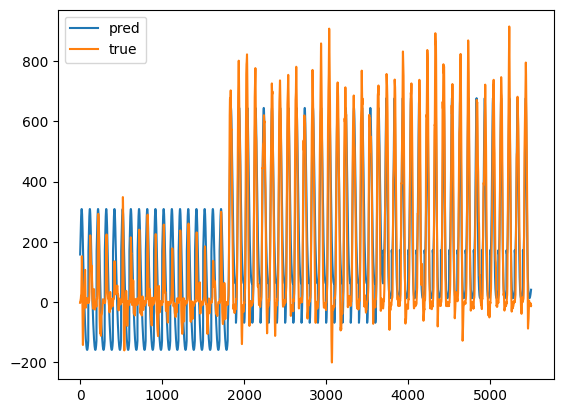

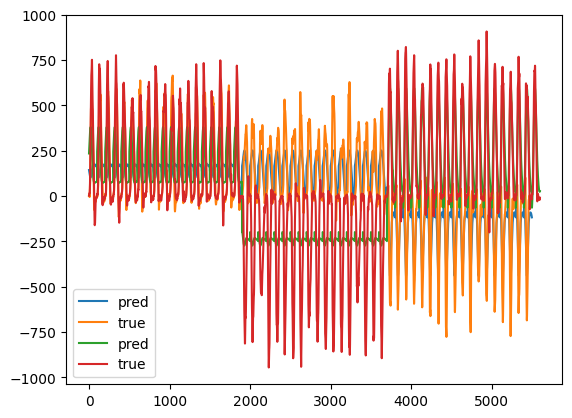

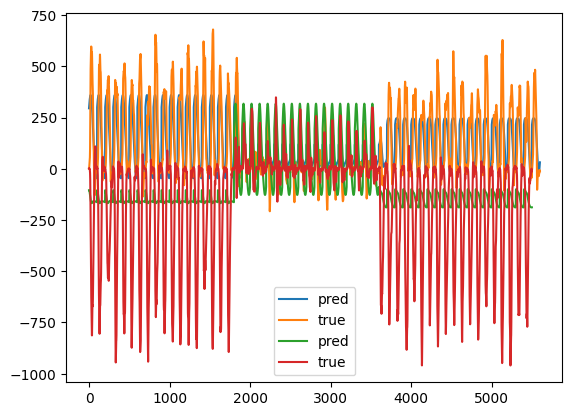

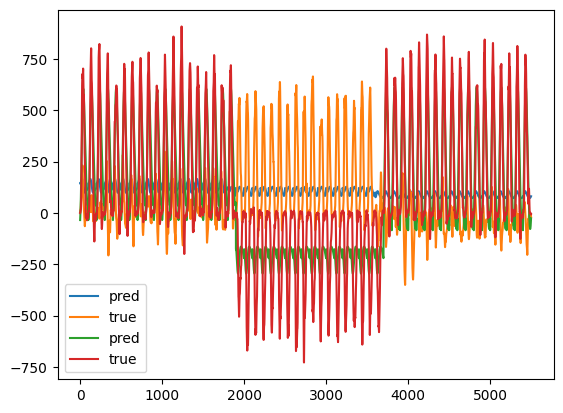

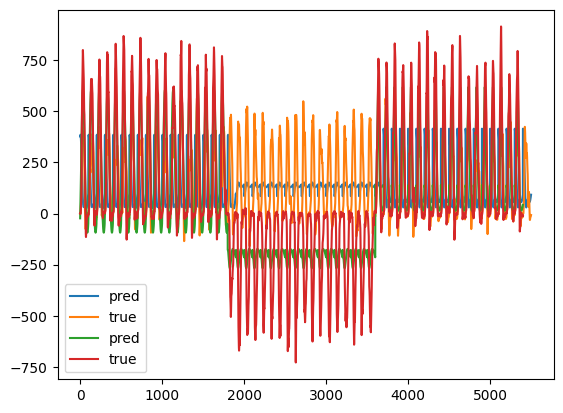

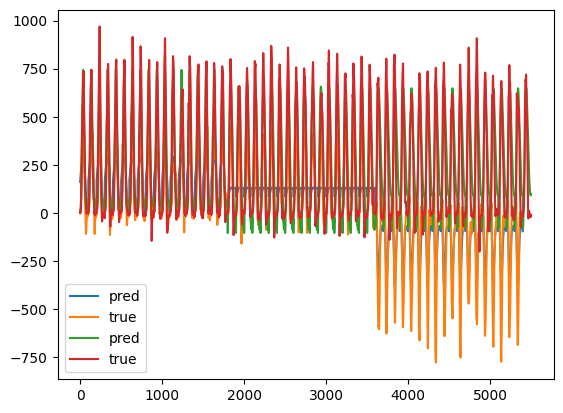

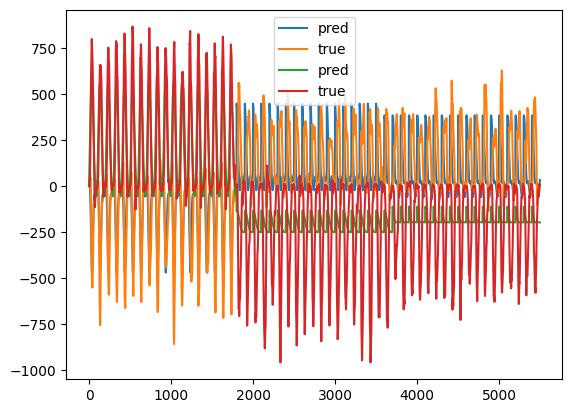

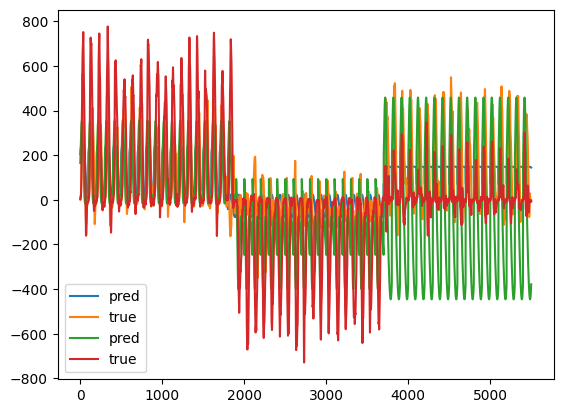

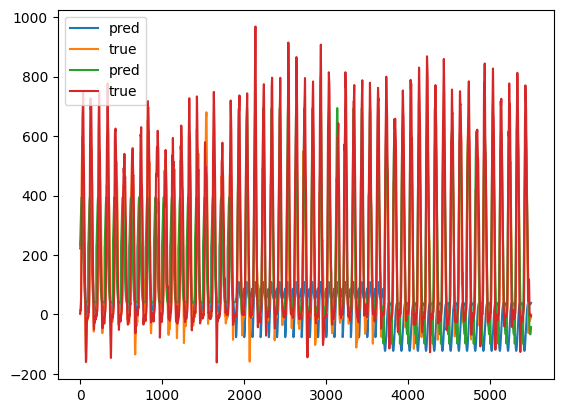

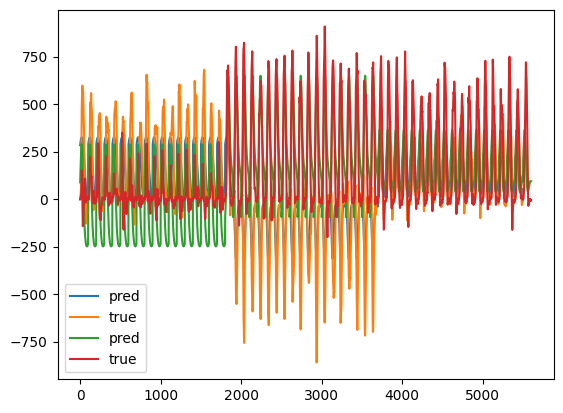

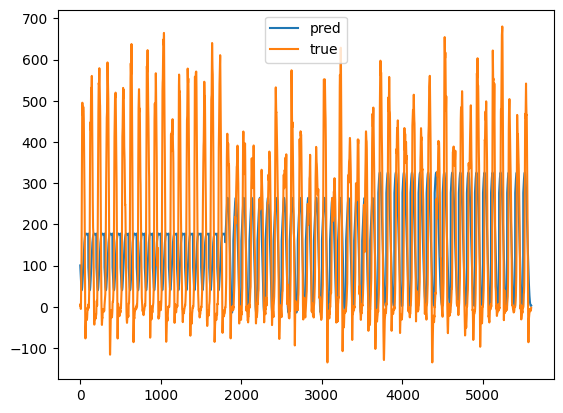

In [66]:


path = '' # set path to ccGPFA experiment results (base directory) 
path = '/media/yido/additional/research/Gitlab/gpfa/ccgpfa/output/MC_Maze_L/' # new 
# path = '/media/yido/additional/research/Gitlab/gpfa/icml_experiments/MC_Maze_L/' # old 
    
n_inducing = None
exp_type = 'binom' # 'binom'
train_rates, train_behavior = [], []
test_rates, test_behavior = [], []


import random 
random.seed(0) # change this to rng 
conds =  [(2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (10, 0), (12, 0), (11, 0)]
test_scores = []
for i in range(10):
    random.shuffle(conds )
    print(conds)
    train_conds, test_conds = conds[:-3], conds[-3:]


    train_rates, train_behavior = load_data(train_conds, exp_type, model='ccgpfa', n_inducing=n_inducing)
    test_rates, test_behavior = load_data(test_conds, exp_type, model='ccgpfa', n_inducing=n_inducing)


    train_rates = np.vstack(np.vstack(train_rates).swapaxes(-1, -2))
    train_behavior = np.vstack(np.vstack(train_behavior))

    test_rates = np.vstack(np.vstack(test_rates).swapaxes(-1, -2))
    test_behavior = np.vstack(np.vstack(test_behavior))
    print(train_rates.shape, test_rates.shape, train_behavior.shape, test_behavior.shape )

    _, test_score_ = test_decode(train_rates, test_rates, train_behavior, test_behavior)
    test_scores.append(test_score_)
print(np.mean(test_scores))

### Baseline - bGPFA 

[(12, 0), (8, 0), (3, 0), (6, 0), (7, 0), (4, 0), (2, 0), (11, 0), (10, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.180, test score - 0.239
[(3, 0), (12, 0), (6, 0), (10, 0), (2, 0), (8, 0), (7, 0), (4, 0), (11, 0)]
(10900, 162) (5600, 162) (10900, 2) (5600, 2)
Train score - 0.142, test score - 0.253
[(6, 0), (3, 0), (10, 0), (11, 0), (7, 0), (8, 0), (4, 0), (2, 0), (12, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - -0.029, test score - 0.164
[(2, 0), (4, 0), (12, 0), (10, 0), (6, 0), (7, 0), (11, 0), (8, 0), (3, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.100, test score - 0.177
[(4, 0), (11, 0), (7, 0), (2, 0), (12, 0), (6, 0), (3, 0), (8, 0), (10, 0)]
(11100, 162) (5400, 162) (11100, 2) (5400, 2)
Train score - 0.028, test score - 0.351
[(7, 0), (12, 0), (10, 0), (2, 0), (4, 0), (8, 0), (6, 0), (3, 0), (11, 0)]
(11000, 162) (5500, 162) (11000, 2) (5500, 2)
Train score - 0.172, test score - 0.175
[(10, 0), (2, 0), (7, 0), (

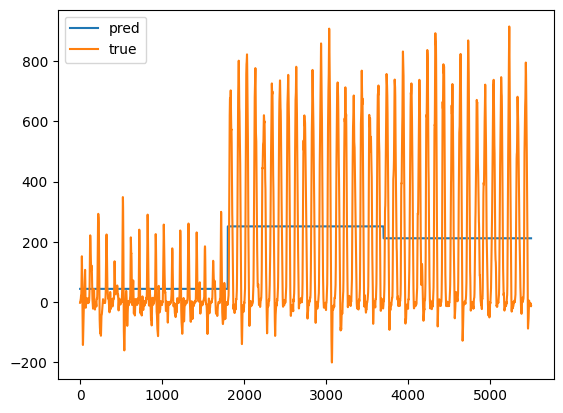

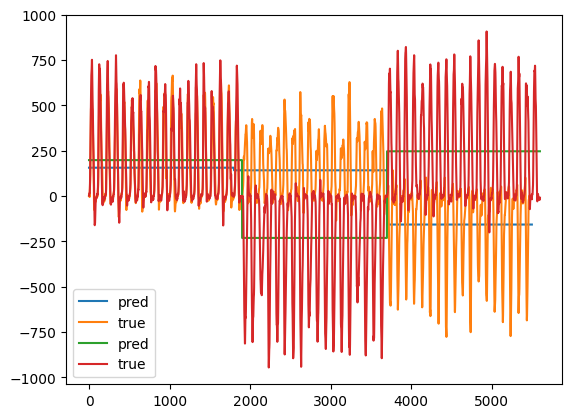

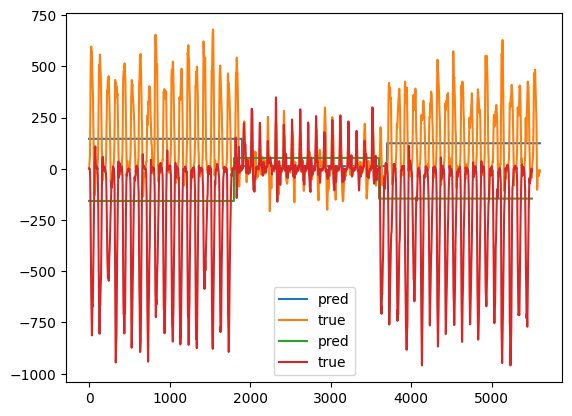

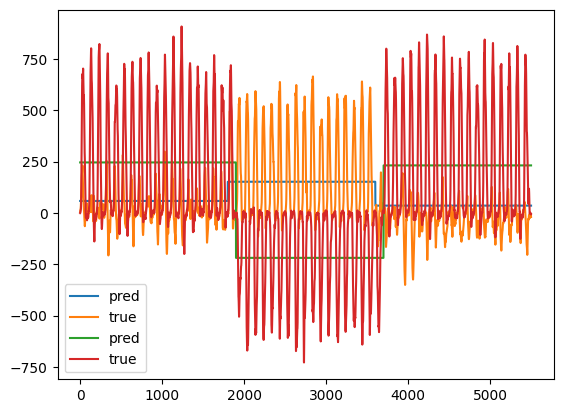

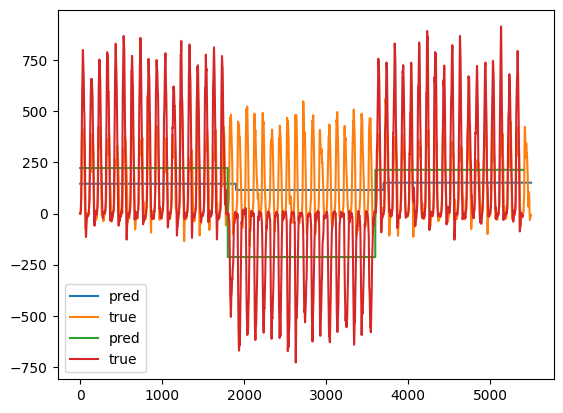

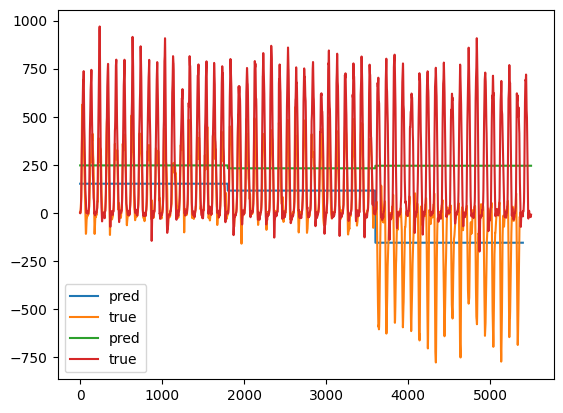

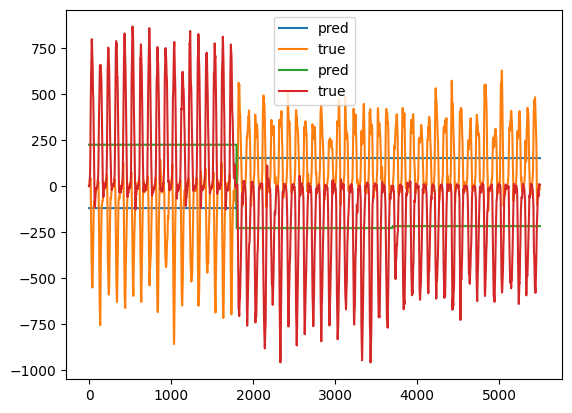

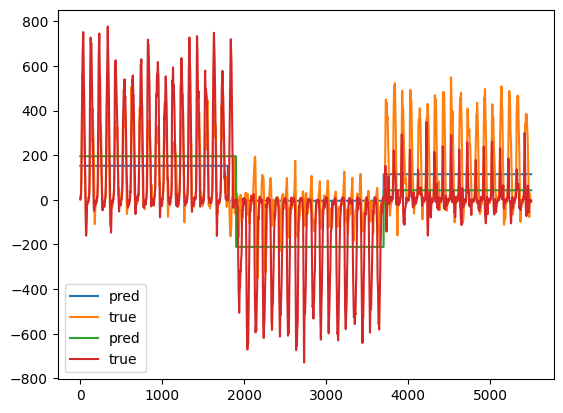

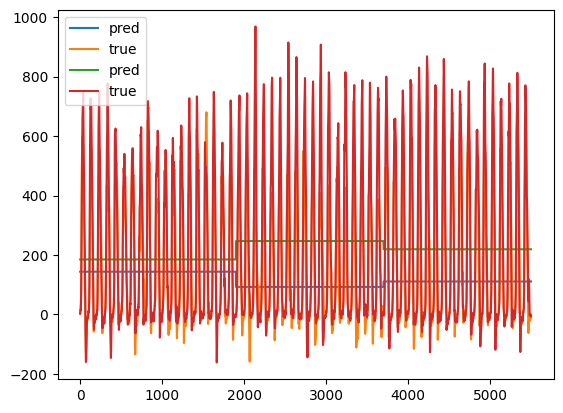

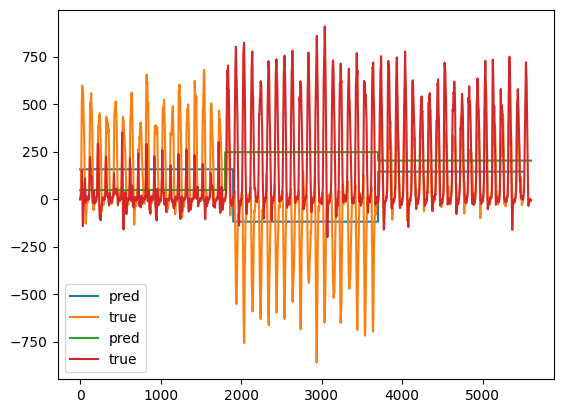

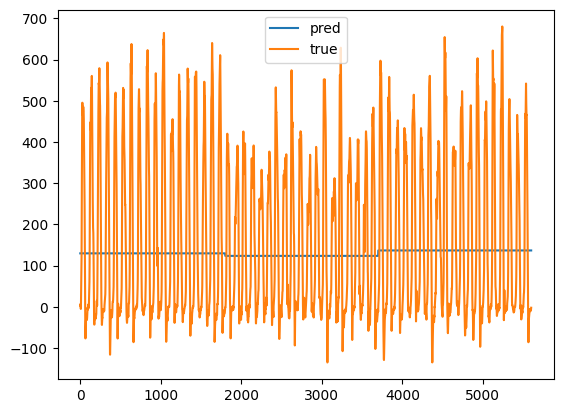

In [67]:
import glob 
exp_type = 'negbinom' # 'binom'
train_rates, train_behavior = [], []
test_rates, test_behavior = [], []

path = '' # set path to bGPFA experiment results (base directory) 
path = '/media/yido/additional/research/Gitlab/gpfa/ccgpfa/output/MC_Maze_L/' # new 


import random 
random.seed(0) # change this to rng 
conds =  [(2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (10, 0), (12, 0), (11, 0)]
test_scores = []
for i in range(10):
    random.shuffle(conds )
    print(conds)
    train_conds, test_conds = conds[:-3], conds[-3:]


    train_rates, train_behavior = load_data(train_conds, exp_type, model='bgpfa')
    test_rates, test_behavior = load_data(test_conds, exp_type, model='bgpfa')


    train_rates = np.vstack(np.vstack(np.vstack(train_rates).swapaxes(-1, -2)))
    train_behavior = np.vstack(np.vstack(train_behavior))

    test_rates = np.vstack(np.vstack(test_rates).swapaxes(-1, -2))
    test_behavior = np.vstack(np.vstack(test_behavior))

    print(train_rates.shape, test_rates.shape, train_behavior.shape, test_behavior.shape )

    _, test_score_ = test_decode(train_rates, test_rates, train_behavior, test_behavior)
    test_scores.append(test_score_)
    
print(np.mean(test_scores))

### Baseline - PAL 

[(12, 0), (8, 0), (3, 0), (6, 0), (7, 0), (4, 0), (2, 0), (11, 0), (10, 0)]
Train score - 0.707, test score - 0.790
[(3, 0), (12, 0), (6, 0), (10, 0), (2, 0), (8, 0), (7, 0), (4, 0), (11, 0)]
Train score - 0.668, test score - 0.586
[(6, 0), (3, 0), (10, 0), (11, 0), (7, 0), (8, 0), (4, 0), (2, 0), (12, 0)]
Train score - 0.612, test score - -0.144
[(2, 0), (4, 0), (12, 0), (10, 0), (6, 0), (7, 0), (11, 0), (8, 0), (3, 0)]
Train score - 0.632, test score - 0.707
[(4, 0), (11, 0), (7, 0), (2, 0), (12, 0), (6, 0), (3, 0), (8, 0), (10, 0)]
Train score - 0.299, test score - 0.826
[(7, 0), (12, 0), (10, 0), (2, 0), (4, 0), (8, 0), (6, 0), (3, 0), (11, 0)]
Train score - 0.736, test score - 0.619
[(10, 0), (2, 0), (7, 0), (11, 0), (6, 0), (4, 0), (3, 0), (12, 0), (8, 0)]
Train score - 0.594, test score - 0.721
[(4, 0), (3, 0), (12, 0), (10, 0), (11, 0), (6, 0), (7, 0), (8, 0), (2, 0)]
Train score - 0.802, test score - 0.349
[(10, 0), (4, 0), (8, 0), (12, 0), (2, 0), (11, 0), (7, 0), (6, 0), (3,

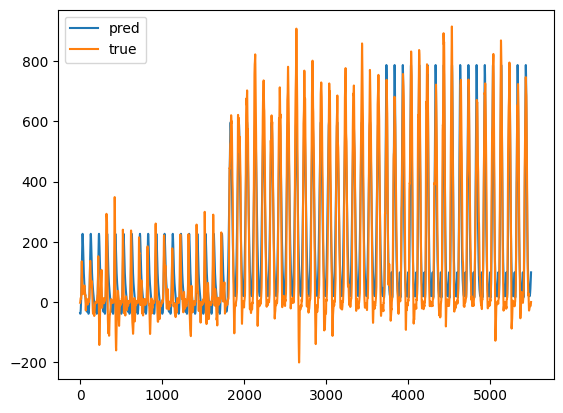

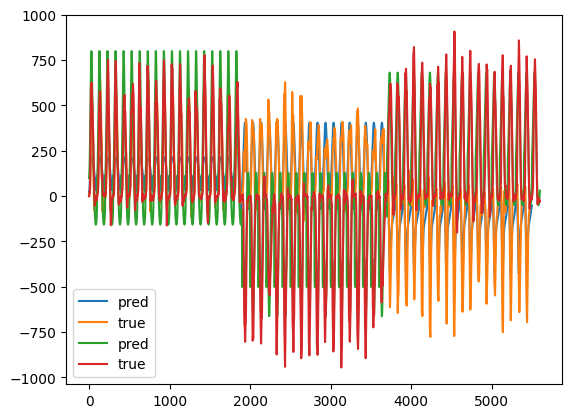

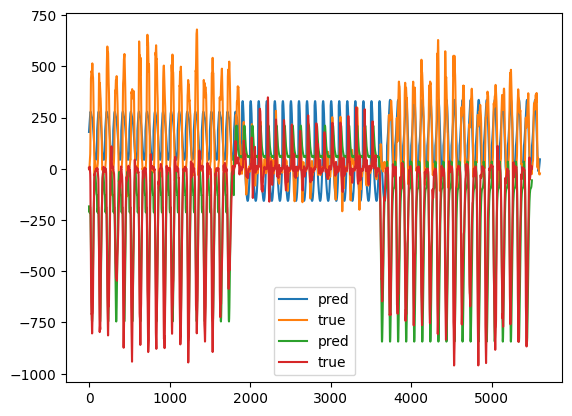

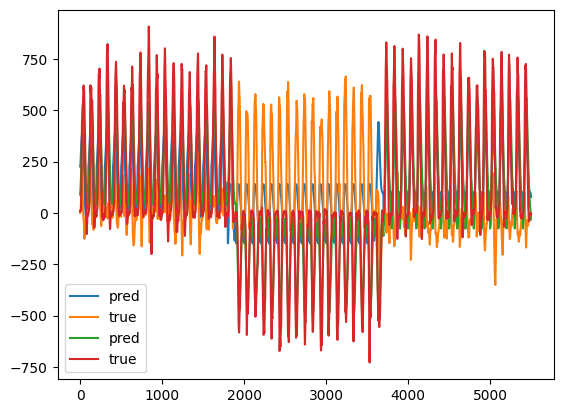

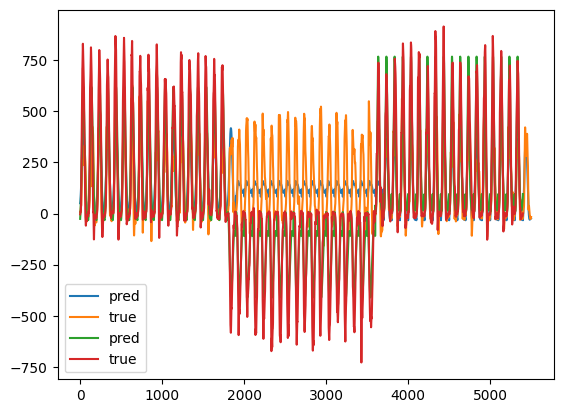

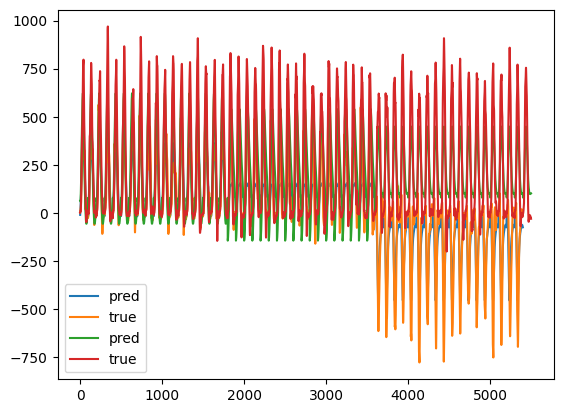

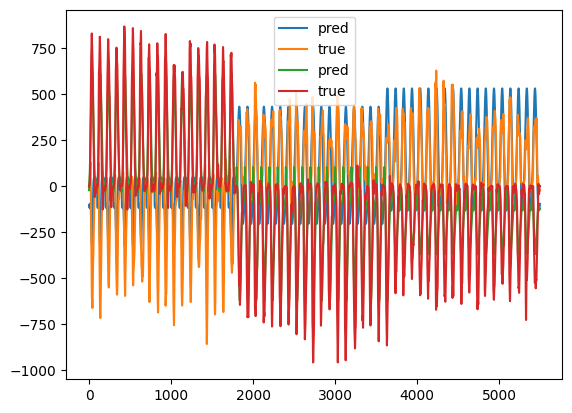

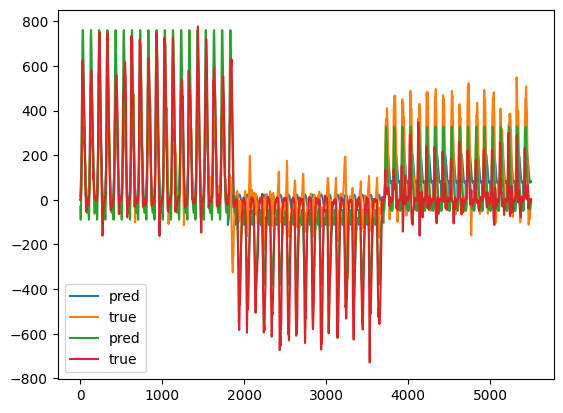

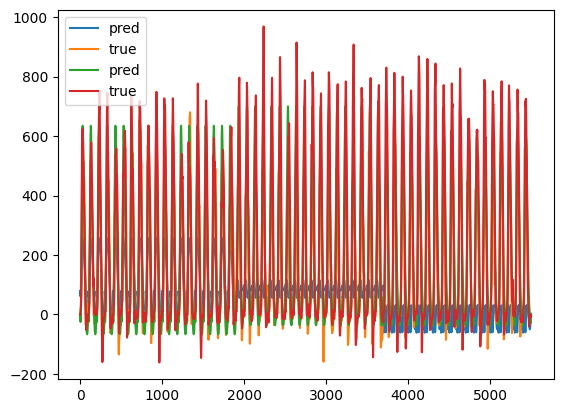

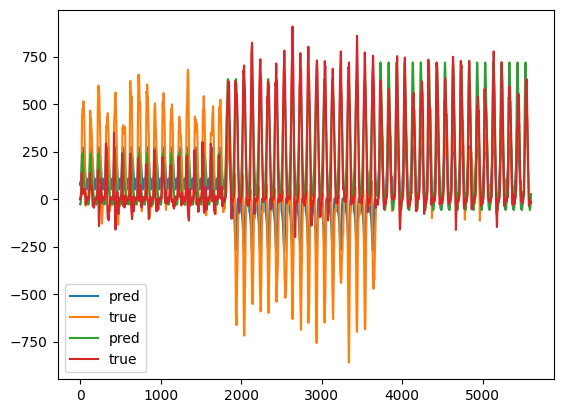

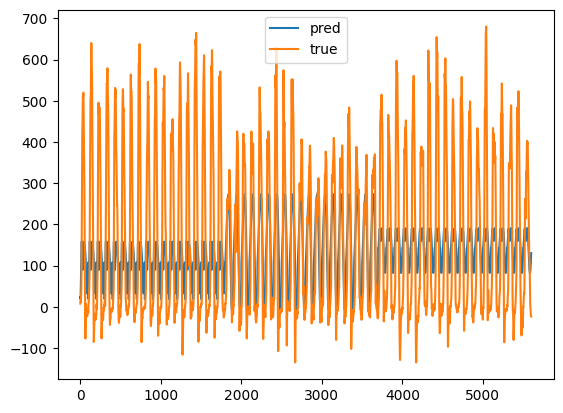

In [72]:
import glob 
train_rates, train_behavior = [], []
test_rates, test_behavior = [], []
exp_type = 'pal'
path = '../../Count_GPFA/maze_results.final/' # set path to PAL experiments results (base directory) 


import random 
random.seed(0) # change this to rng 
conds =  [(2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (10, 0), (12, 0), (11, 0)]
test_scores = []
for i in range(10):
    random.shuffle(conds )
    print(conds)
    train_conds, test_conds = conds[:-3], conds[-3:]

    train_rates, train_behavior = load_data(train_conds, exp_type, model='pal')
    test_rates, test_behavior = load_data(test_conds, exp_type, model='pal')

    train_rates = np.vstack(np.vstack(np.vstack(train_rates).swapaxes(-1, -2)))
    train_behavior = np.vstack(np.vstack(train_behavior))

    test_rates = np.vstack(np.vstack(test_rates).swapaxes(-1, -2))
    test_behavior = np.vstack(np.vstack(test_behavior))

    _, test_score_ = test_decode(train_rates, test_rates, train_behavior, test_behavior)
    test_scores.append(test_score_)
    
print(np.mean(test_scores))

## Running times 